# Quadratically constrained quadratic programming and its applications in portfolio optimization

# Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter , it may be because you have not installed this extension.  Details at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html

The notebook is also not rendered well by GitHub so if you are reading it from there, you may prefer the [pdf version instead](./static/portfolio_optimization_qcqp.pdf).

# Installing the NAG library and running this notebook

This notebook depends on the NAG library for Python to run. Please read the instructions in the [Readme.md](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#install) file to download, install and obtain a licence for the library.

Instruction on how to run the notebook can be found [here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#jupyter).

# Introduction

Quadratically constrained quadratic programming (QCQP) is a type of optimization problem in which both the objective function and the constraints involve quadratic functions. A general QCQP problem has the following form
\begin{equation}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} &  \frac{1}{2}x^TP_0x+q_0^Tx+r_0\\[0.6ex]
\mbox{subject to} & \frac{1}{2}x^TP_ix+q_i^Tx+r_i\leq0,\quad i=1,\ldots,p.
\end{array}
\end{equation}
It appears in applications such as modern portfolio theory, machine learning, engineering and control. Convex QCQP is usually handled through conic optimization, or, more precisely, second-order cone programming (SOCP) due to its computational efficiency and ability to detect infeasibility. However, using SOCP to solve convex QCQP is nontrivial task which requires extra amount of effort to transform problem data and add auxiliary variables. In this notebook, we are going to demonstrate how to use the *NAG Optimization Modelling Suite* in the NAG Library to define and solve QCQP in portfolio optimization.

# Data Preparation

We consider daily prices for the 30 stocks in the DJIA from March 2018 to March 2019. In practice, the estimation of the mean return $r$ and covariance $V$ is often a nontrivial task. In this notebook, we estimate those entities using simple sample estimates.

In [1]:
# Import necessary libraries
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load stock price data from stock_price.plk
# Stock_price: dict = ['close_price': [data], 'date_index': [data]]
stock_price = stock_price = pkl.load(open('./data/stock_price.pkl', 'rb'))
close_price = stock_price['close_price']
date_index = stock_price['date_index']

In [4]:
# Size of data, m: number of observations, n: number of stocks
m = len(date_index)
n = len(close_price)

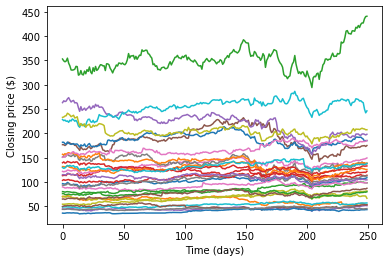

In [5]:
# Extract stock closing prices to a numpy array
data = np.zeros(shape=(m, n))
i = 0
for stock in close_price:
    data[:,i] = close_price[stock]
    plt.plot(np.arange(m), data[:,i])
    i += 1
# Plot closing prices
plt.xlabel('Time (days)')
plt.ylabel('Closing price ($)')
plt.show()

For each stock $i$, we first estimate the $j$th daily relative return as $$relative~return_{i,j} = \frac{closing~price_{i,j+1}-closing~price_{i,j}}{closing~price_{i,j}}.$$

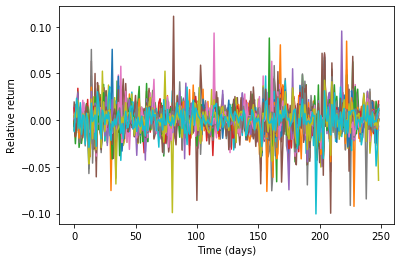

In [6]:
# Relative return
rel_rtn = np.zeros(shape=(m-1, n))
for j in range(m-1):
    rel_rtn[j,:] = np.divide(data[j+1,:] - data[j,:], data[j,:])
# Plot relative return
for i in range(n):
    plt.plot(np.arange(m-1),rel_rtn[:,i])
plt.xlabel('Time (days)')
plt.ylabel('Relative return')
plt.show()

Simply take arithmetic mean of each column of relative return to get mean return $r$ for each stock, followed by estimating covariance $V$ using numpy.

In [7]:
# Mean return
r = np.zeros(n)
r = rel_rtn.sum(axis=0)
r = r / (m-1)
# Covariance matrix
V = np.cov(rel_rtn.T)

# Classic Mean-Variance Model
## Efficient Frontier

One of the major goals of portfolio management is to achieve a certain level of return under a specific risk measurement. Here we demonstrate how to use NAG Library to build efficient frontier by solving classical Markowitz model with long-only constraint (meaning, buy to hold and short selling is not allowed):
\begin{equation}\label{MV_model}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & -r^Tx+\mu x^TVx\\[0.6ex]
\mbox{subject to} & e^Tx = 1,\\[0.6ex]
     & x\geq0,
\end{array}
\end{equation}
where $e\in\Re^n$ is vector of all ones and $\mu$ is a scalar controling trade-off between return and risk. Note one could build the efficient frontier by varying $\mu$ from $0$ to a certain value.

In [8]:
# Import the NAG Library
from naginterfaces.base import utils
from naginterfaces.library import opt
# Import necessary math libraries
import math as mt
import warnings as wn

In [9]:
# Input for quadratic objective
# Sparsity pattern of upper triangular V
irowq, icolq = np.nonzero(np.triu(V))
v_val = V[irowq, icolq]
# Convert to 1-based
irowq = irowq + 1
icolq = icolq + 1
# Sparsity pattern of r, which is actually dense in this application
idxr = np.arange(1, n+1)

# Input for linear constraint: e'x = 1
irowa = np.full(n, 1, dtype=int)
icola = np.arange(1, n+1)
a = np.full(n, 1.0, dtype=float)
bl = np.full(1, 1.0, dtype=float)
bu = np.full(1, 1.0, dtype=float)

# Input for bound constraint: x >= 0
blx = np.zeros(n)
bux = np.full(n, 1.e20, float)

The input data is ready, we can easily build the efficient frontier as follows.

In [10]:
# Set step for mu
step = 2001

# Initialize output data: absolute risk and return
ab_risk = np.empty(0, float)
ab_rtn = np.empty(0, float)

for mu in np.linspace(0.0, 2000.0, step):
    # Create problem handle
    handle = opt.handle_init(n)
    
    # Set quadratic objective function
    # In qcqp standard form q should be 2*mu*V
    q = 2.0 * mu * v_val
    idqc = -1
    opt.handle_set_qconstr(handle, 0.0, idqc, idxr, -r, irowq, icolq, q)
    
    # Set linear constraint e'x = 1
    opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)
    
    # Set bound constraint
    opt.handle_set_simplebounds(handle, blx, bux)
    
    # Set options
    for option in [
            'Print Options = NO',
            'Print Level = 1',
            'Print File = -1',
            'SOCP Scaling = A'
    ]:
        opt.handle_opt_set(handle, option)
        
    # Call socp interior point solver
    # Mute warnings and do not count results from warnings
    wn.simplefilter('error', utils.NagAlgorithmicWarning)
    try:
        slt = opt.handle_solve_socp_ipm(handle)

        # Compute risk and return from the portfolio
        ab_risk = np.append(ab_risk, mt.sqrt(slt.x[0:n].dot(V.dot(slt.x[0:n]))))
        ab_rtn = np.append(ab_rtn, r.dot(slt.x[0:n]))
    except utils.NagAlgorithmicWarning:
        pass
    
    # Destroy the handle:
    opt.handle_free(handle)

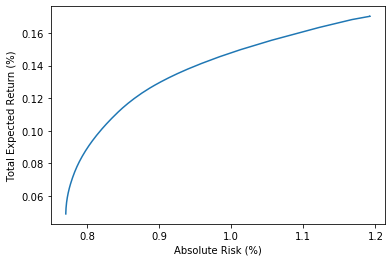

In [11]:
# plot the result
plt.plot(ab_risk*100.0, ab_rtn*100.0)
plt.ylabel('Total Expected Return (%)')
plt.xlabel('Absolute Risk (%)')
plt.show()

## Maximizing the Sharpe ratio

The Sharpe ratio is defined as the ratio of return of portfolio and standard deviation of the portfolio's excess return. It is usually used to measure the efficiency of a portfolio. Find the most efficient portfolio is equivalent to solve the following optimization problem.
\begin{equation}\label{sr_model}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & \frac{\sqrt{x^TVx}}{r^Tx}\\[0.6ex]
\mbox{subject to} & e^Tx = 1,\\[0.6ex]
     & x\geq0.
\end{array}
\end{equation}
By replacing $x$ with $\frac{y}{\lambda}, \lambda\gt0$, model (\ref{sr_model}) is equivalent to
\begin{equation}\label{sr_model_eq}
\begin{array}{ll}
\underset{y\in\Re^n, \lambda\in\Re}{\mbox{minimize}} & y^TVy\\[0.6ex]
\mbox{subject to} & e^Ty = \lambda,\\[0.6ex]
     & r^Ty=1, \\
     & y\geq0, \\
     & \lambda\geq0.
\end{array}
\end{equation}
Problem (\ref{sr_model_eq}) is similar to problem (\ref{MV_model}) in the sense that they both have a quadratic objective function and linear constraints.

In [12]:
# Input for linear constraint: e'y = lambda
irowa = np.full(n+1, 1, dtype=int)
icola = np.arange(1, n+2)
a = np.append(np.full(n, 1.0, dtype=float), -1.0)
bl = np.zeros(1)
bu = np.zeros(1)

# Inpute for linear constraint: r'y = 1
irowa = np.append(irowa, np.full(n, 2, dtype=int))
icola = np.append(icola, np.arange(1, n+1))
a = np.append(a, r)
bl = np.append(bl, 1.0)
bu = np.append(bu, 1.0)

# Input for bound constraint: x >= 0
blx = np.zeros(n+1)
bux = np.full(n+1, 1.e20, float)

Now we can call the NAG SOCP solver as follows.

In [13]:
# Create problem handle
handle = opt.handle_init(n+1)

# Set quadratic objective function
# In qcqp standard form q should be 2*V
q = 2.0 * v_val
idqc = -1
opt.handle_set_qconstr(handle, 0.0, idqc, irowq=irowq, icolq=icolq, q=q)

# Set linear constraints
opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)
    
# Set bound constraint
opt.handle_set_simplebounds(handle, blx, bux)
    
# Set options
for option in [
        'Print Options = NO',
        'Print Level = 1',
        'Print File = -1',
        'SOCP Scaling = A'
]:
    opt.handle_opt_set(handle, option)
        
# Call socp interior point solver
slt = opt.handle_solve_socp_ipm(handle)

sr_risk = mt.sqrt(slt.x[0:n].dot(V.dot(slt.x[0:n])))/slt.x[n]
sr_rtn = r.dot(slt.x[0:n])/slt.x[n]
sr_x = slt.x[0:n]/slt.x[n]

# Destroy the handle:
opt.handle_free(handle)

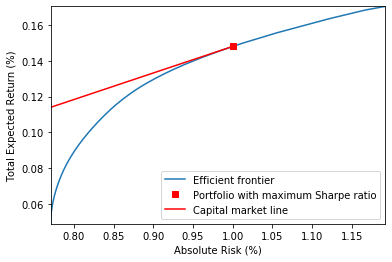

In [14]:
# plot result.
plt.plot(ab_risk*100.0, ab_rtn*100.0, label='Efficient frontier')
plt.plot([sr_risk*100], [sr_rtn*100], 'rs', label='Portfolio with maximum Sharpe ratio')
plt.plot([sr_risk*100, 0.0], [sr_rtn*100, 0.0], 'r-', label='Capital market line')
plt.axis([min(ab_risk*100), max(ab_risk*100), min(ab_rtn*100), max(ab_rtn*100)])
plt.ylabel('Total Expected Return (%)')
plt.xlabel('Absolute Risk (%)')
plt.legend()
plt.show()

# Portfolio optimization with tracking-error constraint

To avoid taking unnecessary risk when beating a benchmark, the investors commonly impose a limit on the volatility of the deviation of the active portfolio from the benchmark, which is also known as tracking-error volatility (TEV) \cite{J03}. The model to build efficient frontier in excess-return space is
\begin{equation}\label{er_tev}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{maximize}} & r^Tx\\
\mbox{subject to} & e^Tx = 0,\\
     & x^TVx\leq tev,
\end{array}
\end{equation}
where $tev$ is a limit on the track-error. Roll \cite{R92} noted that problem (\ref{er_tev}) is totally independent of the benchmark and leads to the unpalatable result that the active portfolio has systematically higher risk than the benchmark and is not optimal. Therefore, in this section we solve a more advanced model by taking absolute risk into account as follows.
\begin{equation}\label{tev_model}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & -r^Tx+\mu (x+b)^TV(x+b)\\
\mbox{subject to} & e^Tx = 0,\\
     & x^TVx\leq tev,\\
     & x+b\geq0,
\end{array}
\end{equation}
where $b$ is a benchmark portfolio. In this demonstration, it is generated synthetically. Note here we use the same covariance matrix $V$ for tev and absolute risk measurement for demonstration purpose. In practice one could use different covariance matrices from different markets.

In [15]:
# Generate a benchmark portfolio from efficient portfolio that maximiz the Sharpe ratio
# Perturb x
b = sr_x + 1.e-1
# Normalize b
b = b/sum(b)

# Set limit on tracking-error
tev = 0.000002

# Compute risk and return at the benchmark
b_risk = mt.sqrt(b.dot(V.dot(b)))
b_rtn = r.dot(b)

In [16]:
# Input for linear constraint: e'x = 0
irowa = np.full(n, 1, dtype=int)
icola = np.arange(1, n+1)
a = np.full(n, 1.0, dtype=float)
bl = np.zeros(1)
bu = np.zeros(1)

# Input for bound constraint: x >= -b
blx = -b
bux = np.full(n, 1.e20, float)

In [17]:
# Initialize output data: TEV risk and return
tev_risk = np.empty(0, float)
tev_rtn = np.empty(0, float)

for mu in np.linspace(0.0, 2000.0, step):
    # Create problem handle
    handle = opt.handle_init(n)
    
    # Set quadratic objective function
    # In qcqp standard form q should be 2*mu*V
    q = 2.0 * mu * v_val
    r_mu = 2.0*mu*V.dot(b)-r
    idqc = -1
    opt.handle_set_qconstr(handle, 0.0, idqc, idxr, r_mu, irowq, icolq, q)
    
    # Set quadratic constraint
    # In qcqp standard form q should be 2*V
    q = 2.0 * v_val
    idqc = 0
    opt.handle_set_qconstr(handle, -tev, idqc, irowq=irowq, icolq=icolq, q=q)
    
    # Set linear constraint e'x = 1
    opt.handle_set_linconstr(handle, bl, bu, irowa, icola, a)
    
    # Set bound constraint
    opt.handle_set_simplebounds(handle, blx, bux)
    
    # Set options
    for option in [
            'Print Options = NO',
            'Print Level = 1',
            'Print File = -1',
            'SOCP Scaling = A'
    ]:
        opt.handle_opt_set(handle, option)
        
    # Call socp interior point solver
    # Mute warnings and do not count results from warnings
    wn.simplefilter('error', utils.NagAlgorithmicWarning)
    try:
        slt = opt.handle_solve_socp_ipm(handle)

#       Compute risk and return from the portfolio
        tev_risk = np.append(tev_risk, mt.sqrt((slt.x[0:n]+b).dot(V.dot(slt.x[0:n]+b))))
        tev_rtn = np.append(tev_rtn, r.dot(slt.x[0:n]+b))
    except utils.NagAlgorithmicWarning:
        pass
    
    # Destroy the handle:
    opt.handle_free(handle)

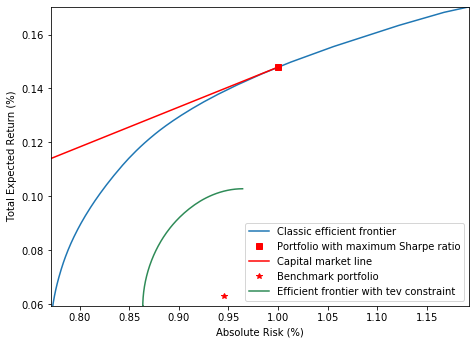

In [18]:
# Plot the result
plt.figure(figsize=(7.5, 5.5))
plt.plot(ab_risk*100.0, ab_rtn*100.0, label='Classic efficient frontier')
plt.plot([sr_risk*100], [sr_rtn*100], 'rs', label='Portfolio with maximum Sharpe ratio')
plt.plot([sr_risk*100, 0.0], [sr_rtn*100, 0.0], 'r-', label='Capital market line')
plt.plot(b_risk*100, b_rtn*100, 'r*', label='Benchmark portfolio')
plt.plot(tev_risk*100.0, tev_rtn*100.0, 'seagreen', label='Efficient frontier with tev constraint')

plt.axis([min(ab_risk*100), max(ab_risk*100), min(tev_rtn*100), max(ab_rtn*100)])
plt.ylabel('Total Expected Return (%)')
plt.xlabel('Absolute Risk (%)')
plt.legend()
plt.show()

# Conclusion

In this notebook, we demonstrated how to use NAG Library to solve various quadratic models in portfolio optimization. Conic optimization is usually a good choice to solve convex QCQP. It is worth pointing out that the versatility of SOCP is not just limited to the QCQP models mentioned here. It covers a lot more problems and constraints. For example, DeMiguel et al. \cite{DGNU09} discussed portfolio optimization with norm constraint, which can be easily transformed into an SOCP problem. We refer readers to the NAG Library documentation \cite{NAGDOC} on SOCP solver and \cite{AG03, LVBL98} for more details.

# References

[<a id="cit-J03" href="#call-J03">1</a>] Jorion Philippe, ``_Portfolio optimization with tracking-error constraints_'', Financial Analysts Journal, vol. 59, number 5, pp. 70--82,  2003.

[<a id="cit-R92" href="#call-R92">2</a>] Roll Richard, ``_A mean/variance analysis of tracking error_'', The Journal of Portfolio Management, vol. 18, number 4, pp. 13--22,  1992.

[<a id="cit-DGNU09" href="#call-DGNU09">3</a>] DeMiguel Victor, Garlappi Lorenzo, Nogales Francisco J <em>et al.</em>, ``_A generalized approach to portfolio optimization: Improving performance by constraining portfolio norms_'', Management science, vol. 55, number 5, pp. 798--812,  2009.

[<a id="cit-NAGDOC" href="#call-NAGDOC">4</a>] Numerical Algorithms Group, ``_NAG documentation_'',  2019.  [online](https://www.nag.com/numeric/fl/nagdoc_latest/html/frontmatter/manconts.html)

[<a id="cit-AG03" href="#call-AG03">5</a>] Alizadeh Farid and Goldfarb Donald, ``_Second-order cone programming_'', Mathematical programming, vol. 95, number 1, pp. 3--51,  2003.

[<a id="cit-LVBL98" href="#call-LVBL98">6</a>] Lobo Miguel Sousa, Vandenberghe Lieven, Boyd Stephen <em>et al.</em>, ``_Applications of second-order cone programming_'', Linear algebra and its applications, vol. 284, number 1-3, pp. 193--228,  1998.

